# Timeseries-Analysis on Cryptocurrency
## load Data

In [103]:
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from random import random
from scipy import signal
from dateutil.parser import parse
#from pandas import read_csv
#from matplotlib import pyplot
import pickle
import quandl
from datetime import datetime, timedelta, date
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

py.init_notebook_mode(connected=True)

In [104]:
data_full = pd.read_csv('../artifacts/data_full.csv')
#data_full['Date'] = pd.to_datetime(data_full['Date'])
data_full['Date'] = [pd.to_datetime(str(x) + ' 00:00:00',format = '%Y-%m-%d %H:%M:%S') for x in data_full['Date']] 
for x in data_full['Date'][:10]:
    print(str(x))
data_full = data_full.set_index('Date')
data_full.index = pd.to_datetime(data_full.index,format = '%Y-%m-%d %H:%M:%S')
data_full.index[:10]

2016-07-25 00:00:00
2016-07-26 00:00:00
2016-07-27 00:00:00
2016-07-28 00:00:00
2016-07-29 00:00:00
2016-07-30 00:00:00
2016-07-31 00:00:00
2016-08-01 00:00:00
2016-08-02 00:00:00
2016-08-03 00:00:00


DatetimeIndex(['2016-07-25', '2016-07-26', '2016-07-27', '2016-07-28',
               '2016-07-29', '2016-07-30', '2016-07-31', '2016-08-01',
               '2016-08-02', '2016-08-03'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [105]:
combined_df_2016 = data_full[data_full.index.year == 2016]

In [106]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2016
combined_df_2016 = data_full[data_full.index.year == 2016]
combined_df_2016.pct_change().corr(method='pearson')

,Unnamed: 0,Gold,Silver,Yuan,ETH,LTC,XRP,ETC,STR,DASH,SC,XMR,XEM,BTC
Unnamed: 0,1.000000,0.109197,0.080871,-0.153836,0.006268,-0.039258,-0.004460,0.017199,-0.029455,0.131643,0.003786,0.021641,-0.020724,-0.122195
Gold,0.109197,1.000000,0.816994,-0.400680,0.061153,0.021064,0.092328,0.091568,-0.006155,-0.081376,0.145112,-0.063484,-0.062300,-0.006501
Silver,0.080871,0.816994,1.000000,-0.335391,0.053671,-0.007755,0.045048,0.094895,-0.078182,-0.114014,0.088913,-0.037266,0.015487,0.015669
Yuan,-0.153836,-0.400680,-0.335391,1.000000,0.013123,0.031666,-0.092114,-0.072479,-0.115053,0.072406,-0.159571,0.111012,0.119244,0.041655
ETH,0.006268,0.061153,0.053671,0.013123,1.000000,0.345344,0.440755,-0.182917,0.111281,0.173641,0.263811,0.219352,0.340521,0.364203
LTC,-0.039258,0.021064,-0.007755,0.031666,0.345344,1.000000,0.175509,-0.163691,0.070436,0.035801,-0.011061,0.307626,0.133253,0.681718
XRP,-0.004460,0.092328,0.045048,-0.092114,0.440755,0.175509,1.000000,-0.160552,0.384092,0.069388,0.156195,0.045570,0.145537,0.068932
ETC,0.017199,0.091568,0.094895,-0.072479,-0.182917,-0.163691,-0.160552,1.000000,-0.120444,-0.050094,-0.020187,-0.113886,-0.085483,-0.177028
STR,-0.029455,-0.006155,-0.078182,-0.115053,0.111281,0.070436,0.384092,-0.120444,1.000000,0.114370,0.038892,-0.035293,0.051242,0.027521
DASH,0.131643,-0.081376,-0.114014,0.072406,0.173641,0.035801,0.069388,-0.050094,0.114370,1.000000,0.095639,0.039306,0.272601,-0.017666


In [107]:
def correlation_heatmap(df, title, absolute_bounds=True):
    '''Plot a correlation heatmap for the entire dataframe'''
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').values,
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)
    
correlation_heatmap(combined_df_2016.pct_change(), "Cryptocurrency Correlations in 2016")

# Autocorrelation

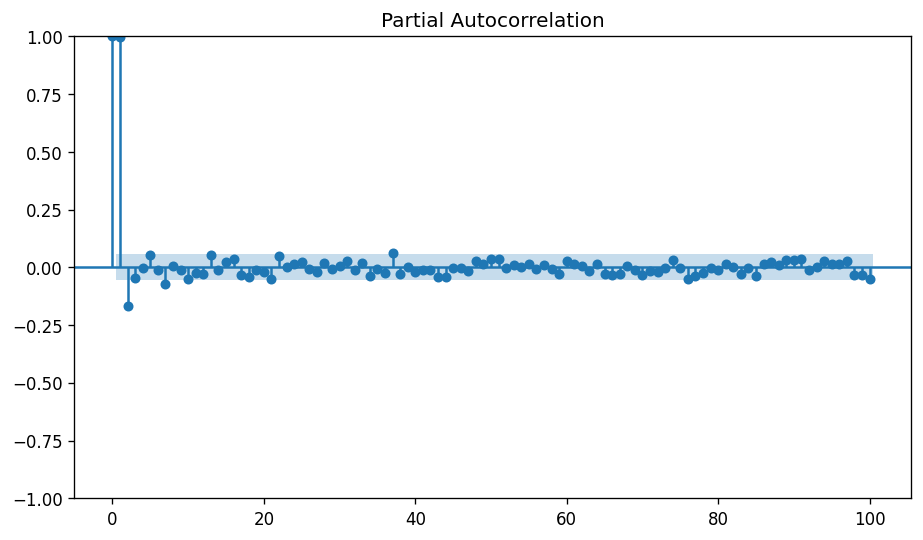

In [108]:


plot_pacf(data_full['BTC'].dropna(),lags = 100)
plt.show()
#combined_df['BTC']

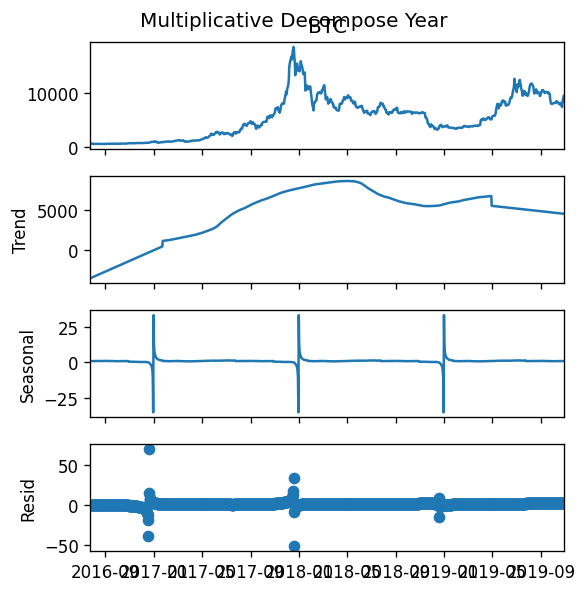

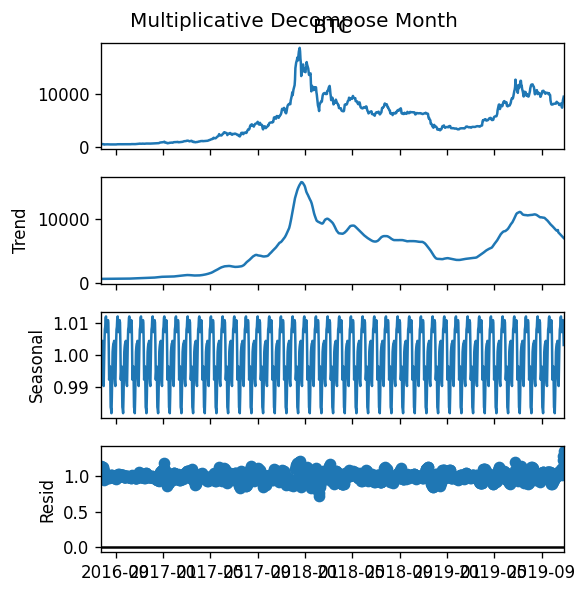

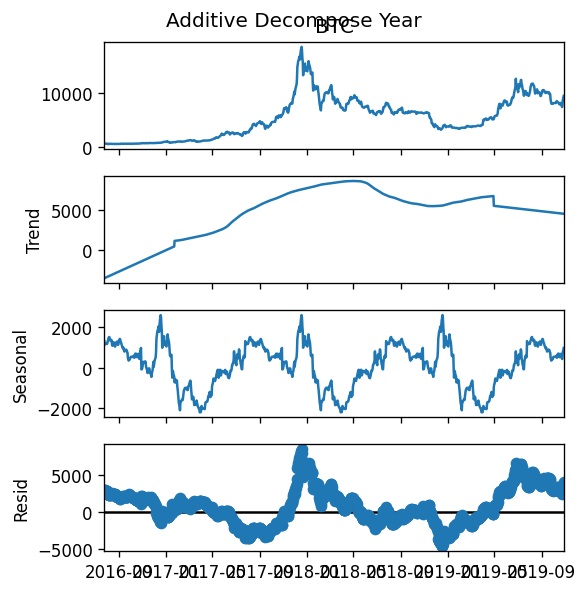

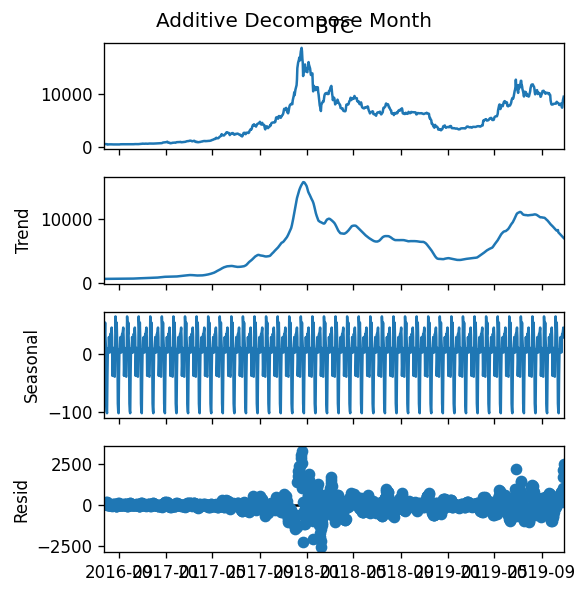

In [109]:

#print(data_full['BTC'].dropna())
# Multiplicative Decomposition 
result_mul = seasonal_decompose(data_full['BTC'].dropna(), model='multiplicative', period = 365,
                                extrapolate_trend='freq'
                               )
result_mul2 = seasonal_decompose(data_full['BTC'].dropna(), model='multiplicative', period = 30,
                                extrapolate_trend='freq'
                               )

# Additive Decomposition
result_add = seasonal_decompose(data_full['BTC'].dropna(), model='additive', period = 365,
                                extrapolate_trend='freq')
result_add2 = seasonal_decompose(data_full['BTC'].dropna(), model='additive', period = 30,
                                extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (5,5)})
result_mul.plot().suptitle('Multiplicative Decompose Year', fontsize=12)
result_mul2.plot().suptitle('Multiplicative Decompose Month', fontsize=12)
result_add.plot().suptitle('Additive Decompose Year', fontsize=12)
result_add2.plot().suptitle('Additive Decompose Month', fontsize=12)
plt.show()

# Make Process Stationary

In [110]:
# ADF Test
result = adfuller(data_full['BTC'].dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(data_full['BTC'].dropna(), regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.8154893231802385
p-value: 0.3727992410304354
Critial Values:
   1%, -3.435956259544601
Critial Values:
   5%, -2.8640155784421606
Critial Values:
   10%, -2.568088052103053

KPSS Statistic: 2.477261
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Michael Nelz\AppData\Local\Temp\ipykernel_23508\2142672882.py:10: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [111]:
#Detrend

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the least squares fit')

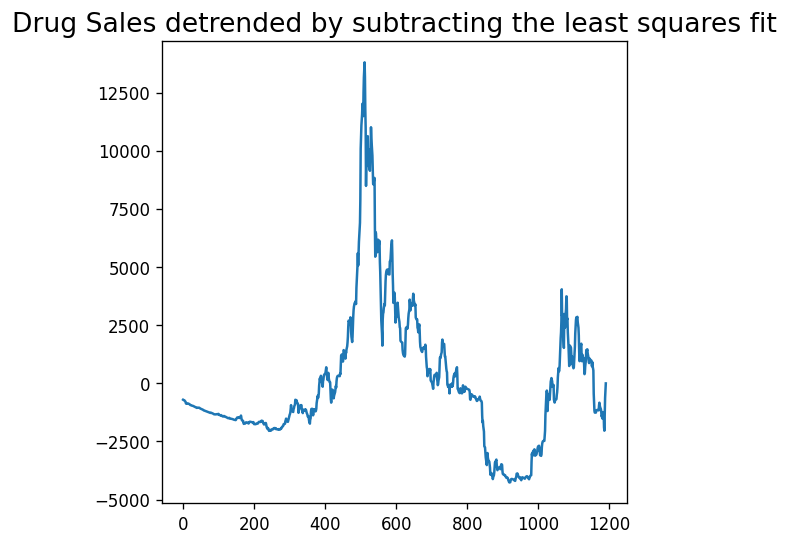

In [112]:
# Using scipy: Subtract the line of best fit
detrended = signal.detrend(data_full['BTC'].dropna())
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

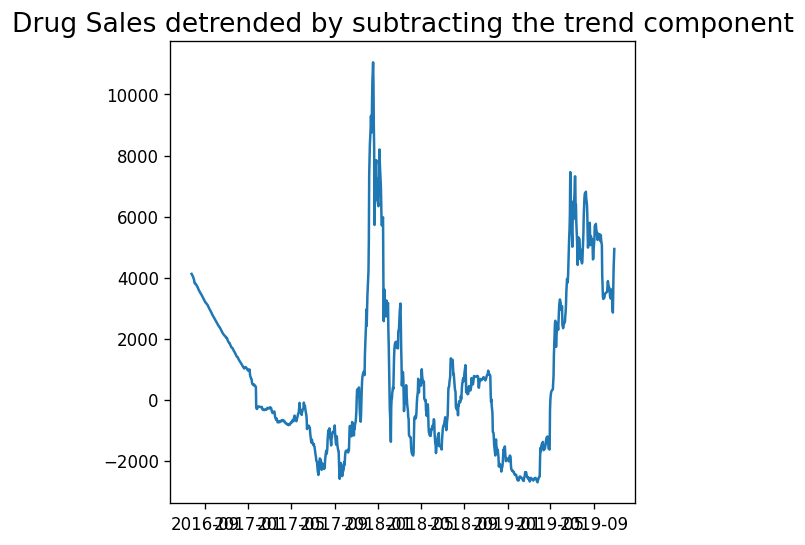

In [113]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(data_full['BTC'].dropna(), model='multiplicative', period = 365, extrapolate_trend='freq')
detrended = data_full['BTC'].dropna() - result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

In [114]:
# Deseasonalize

[]

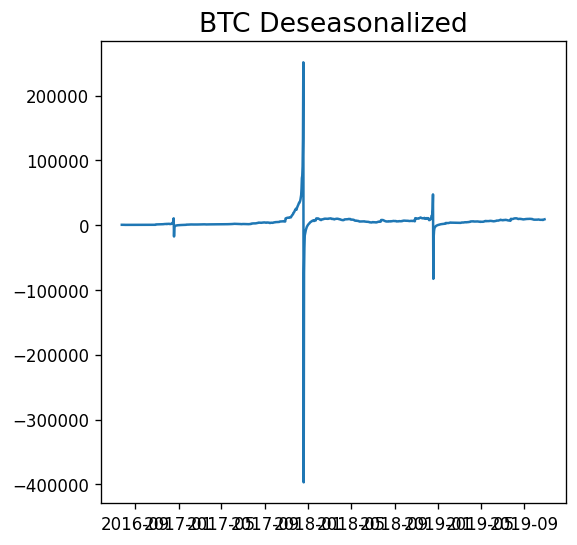

In [115]:
# Subtracting the Trend Component.

# Time Series Decomposition
result_mul = seasonal_decompose(data_full['BTC'].dropna(), model='multiplicative', period = 365, extrapolate_trend='freq')

# Deseasonalize
deseasonalized = data_full['BTC'].dropna() / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('BTC Deseasonalized', fontsize=16)
plt.plot()

# Test for seasonality

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

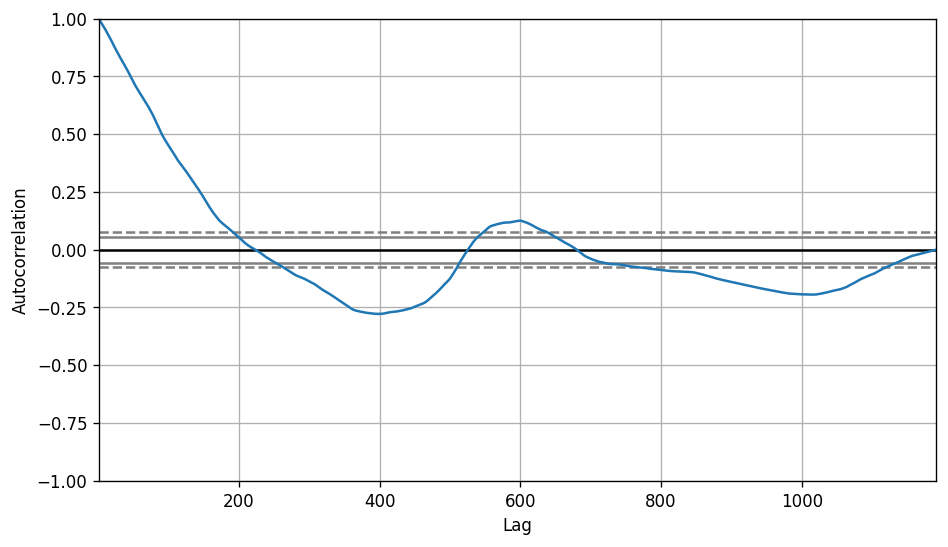

In [116]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(data_full['BTC'].dropna())

In [117]:
# Forecasting
np.max(data_full.index)+timedelta(days = 1)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1191 entries, 2016-07-25 to 2019-10-28
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1191 non-null   int64  
 1   Gold        1191 non-null   float64
 2   Silver      1191 non-null   float64
 3   Yuan        1191 non-null   float64
 4   ETH         1191 non-null   float64
 5   LTC         1191 non-null   float64
 6   XRP         1191 non-null   float64
 7   ETC         1191 non-null   float64
 8   STR         1191 non-null   float64
 9   DASH        1191 non-null   float64
 10  SC          1191 non-null   float64
 11  XMR         1191 non-null   float64
 12  XEM         1191 non-null   float64
 13  BTC         1191 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 139.6 KB


c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: 

2019-10-29    9489.936309
2019-10-30    9469.158882
2019-10-31    9488.266724
2019-11-01    9542.443432
2019-11-02    9598.987726
                 ...     
2020-02-02    9768.603489
2020-02-03    9768.941204
2020-02-04    9771.182405
2020-02-05    9770.887064
2020-02-06    9770.264958
Freq: D, Name: predicted_mean, Length: 101, dtype: float64


c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



<Axes: xlabel='Date'>

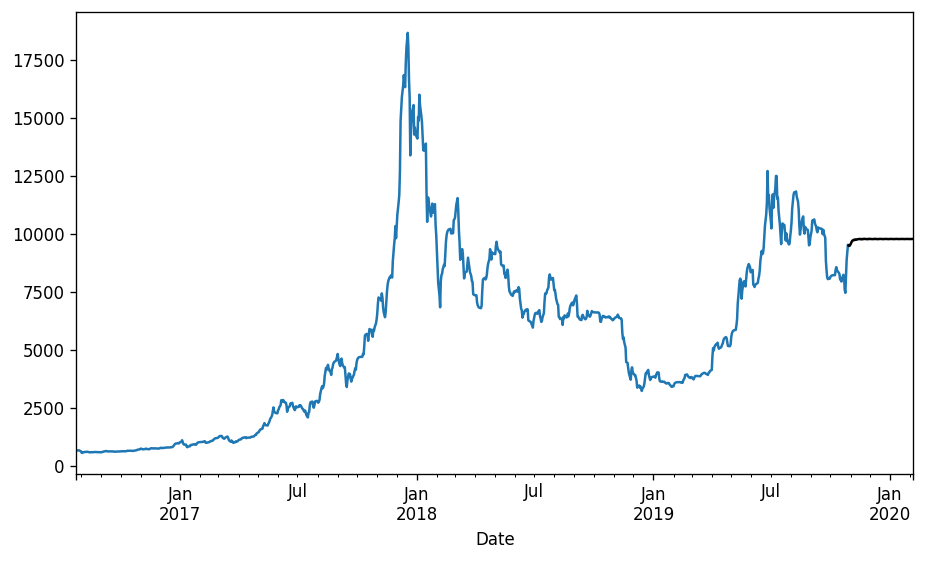

In [118]:
# ARIMA example
# contrived dataset
data = data_full['BTC'].dropna()
#print(data)
# fit model
model = ARIMA(data, order=(10, 1,5))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data)+100, typ='levels')
print(yhat)
data.plot()
yhat.plot(style = '-', color = 'black')

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<Axes: xlabel='Date'>

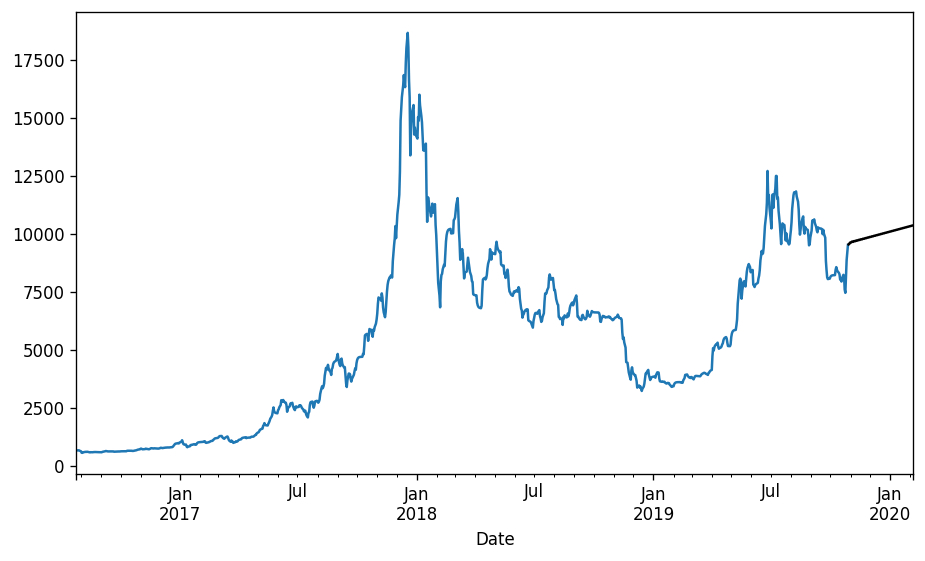

In [119]:
# SARIMA example
# fit model
model = SARIMAX(data, order=(3, 2, 10), seasonal_order=(0,0,0,0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data)+100)
data.plot()
yhat.plot(style = '-', color = 'black')

C:\Users\Michael Nelz\AppData\Local\Temp\ipykernel_23508\2317611261.py:3: FutureWarning:

the 'damped'' keyword is deprecated, use 'damped_trend' instead.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Michael Nelz\AppData\Local\Temp\ipykernel_23508\2317611261.py:6: FutureWarning:

the 'damped'' keyword is deprecated, use 'damped_trend' instead.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinf

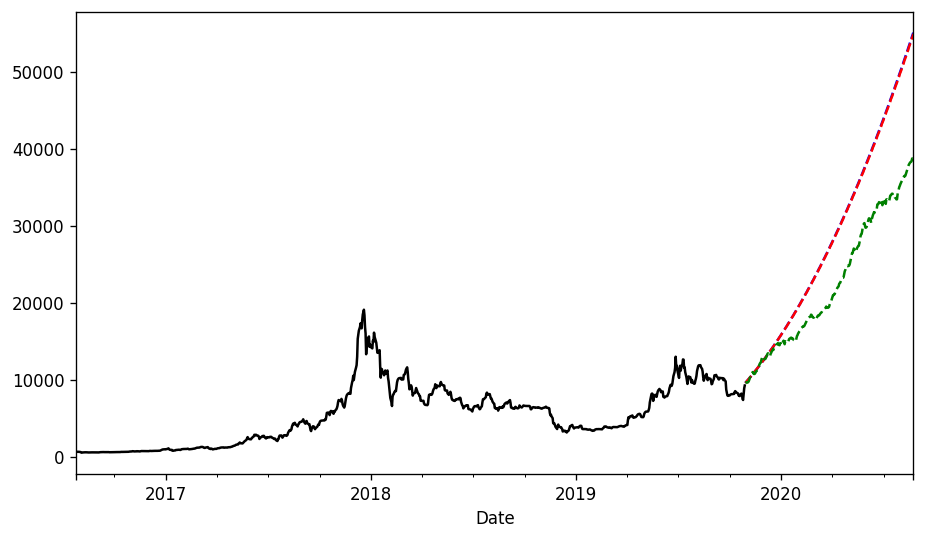

In [120]:
# Hold Winters Exponential Smoothing example
# fit model
model1 = ExponentialSmoothing(data, trend = 'add', seasonal = 'add',
                              seasonal_periods = 4,
                              damped = False, use_boxcox = True)
model2 = ExponentialSmoothing(data, trend = 'add', seasonal = 'mul',
                              seasonal_periods = 4,
                              damped = False, use_boxcox = True)
model3 = ExponentialSmoothing(data, trend = 'add', seasonal = 'add',
                              seasonal_periods =6*30,
                              #damped = True,
                              use_boxcox = True
                              )
model_fit1 = model1.fit()
model_fit2 = model2.fit()
model_fit3 = model3.fit()

# make prediction
forecast_n = 300
yhat = model_fit1.predict(len(data), len(data)+100)
#print(yhat)

model_fit1.fittedvalues.plot(style = '-', color = 'black')
model_fit1.forecast(forecast_n).plot(style = '--', color = 'blue')
model_fit2.forecast(forecast_n).plot(style = '--', color = 'red')
model_fit3.forecast(forecast_n).plot(style = '--', color = 'green')
plt.show()

# Forecasting with further Information
## with Pseudo Data

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



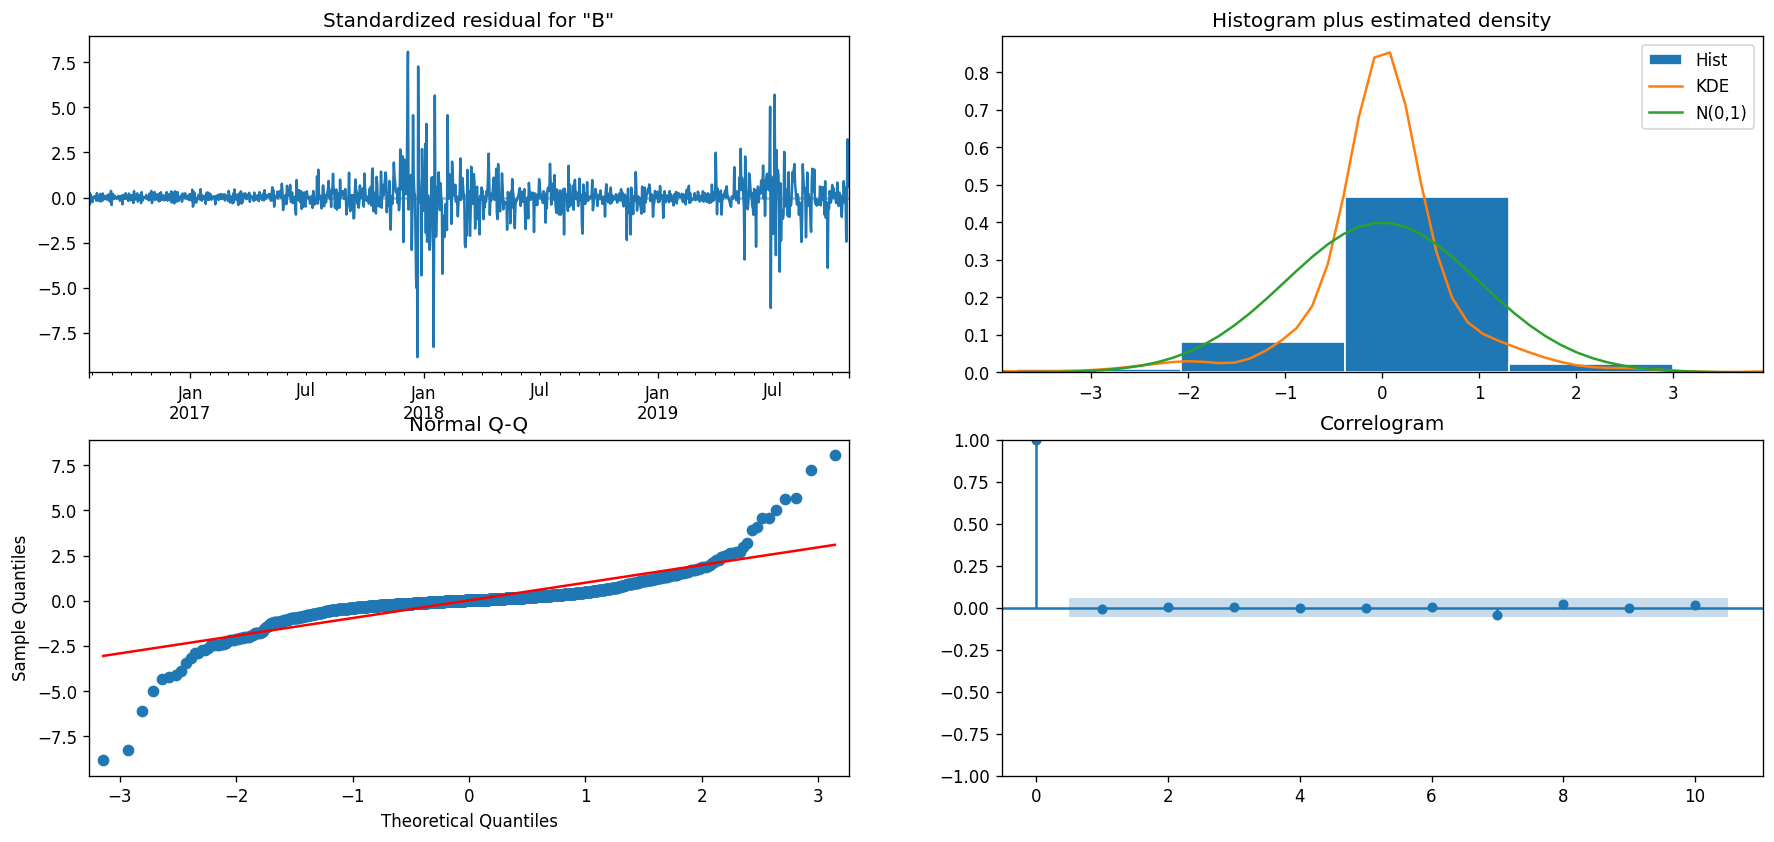

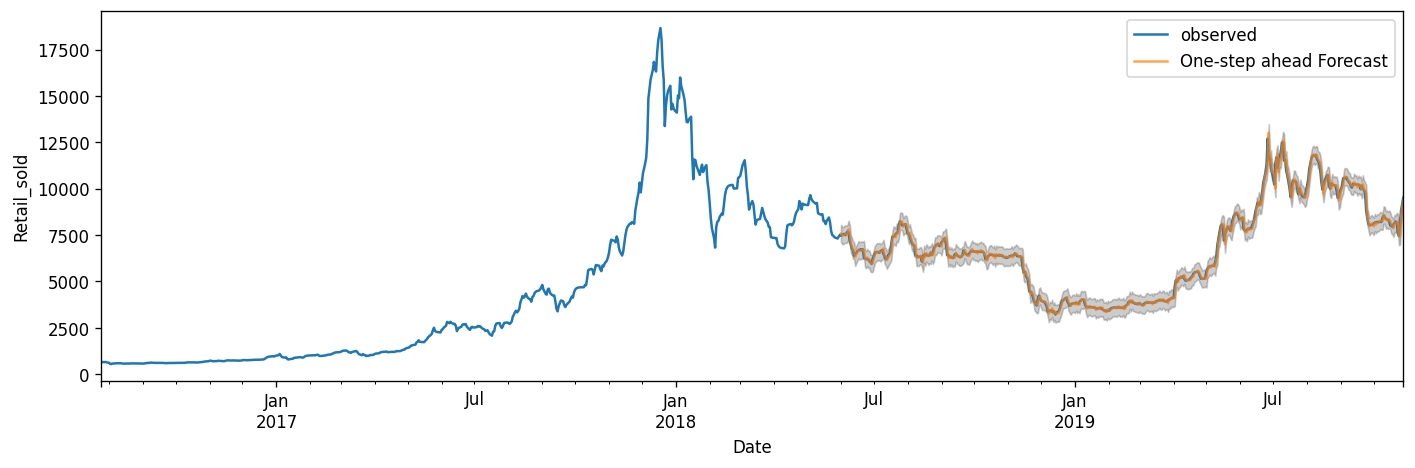

In [121]:
# SARIMAX example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data_ex = [x/10000 + random() for x in data]
#print(data_ex[10])
# fit model
model = SARIMAX(data, exog=data_ex, order=(5, 1, 10), seasonal_order=(0, 0, 0, 48*30))
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()
# make prediction

pred = model_fit.get_prediction(start=pd.to_datetime('2018-06-01'), dynamic=False)

pred_ci = pred.conf_int()
ax = data.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()


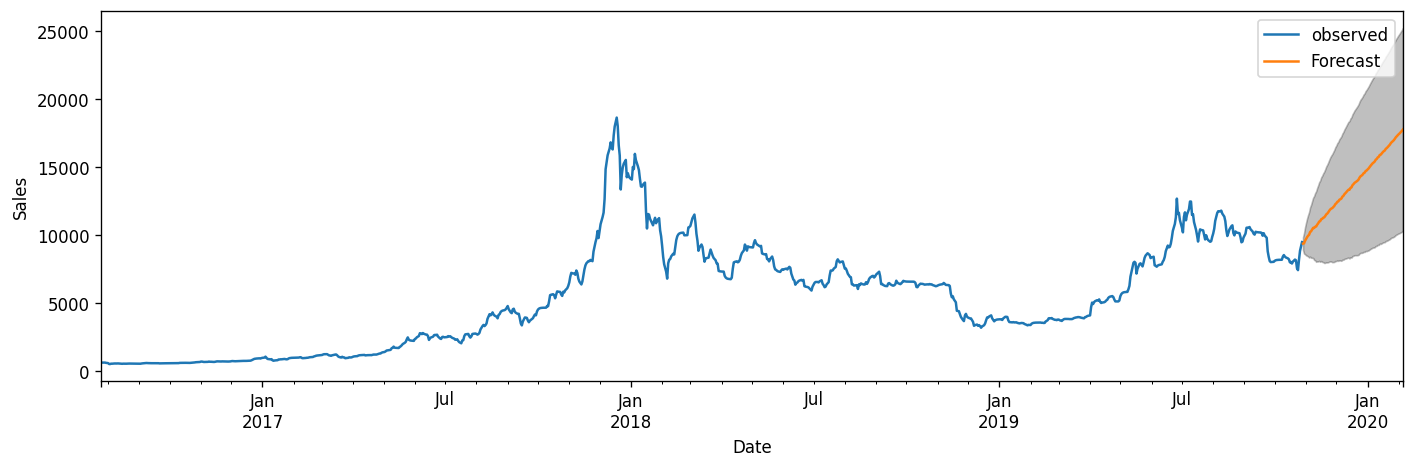

In [122]:
# make forecast
forecast_n = 100
exog2 = [[x + random()] for x in range(0,forecast_n)]
pred_uc = model_fit.get_forecast(steps=forecast_n,exog=exog2)
pred_ci = pred_uc.conf_int()
ax = data.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

# with real Data
Warum 48*30?: <br>
     Weil alle 4 Jahre(48 Monate * 30 Tage) die Bitcoinausschüttung halbiert wird und dadurch (bisher) ein Wachstum stattfand

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\Michael Nelz\.conda\envs\crypto_reinforcement_learning\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



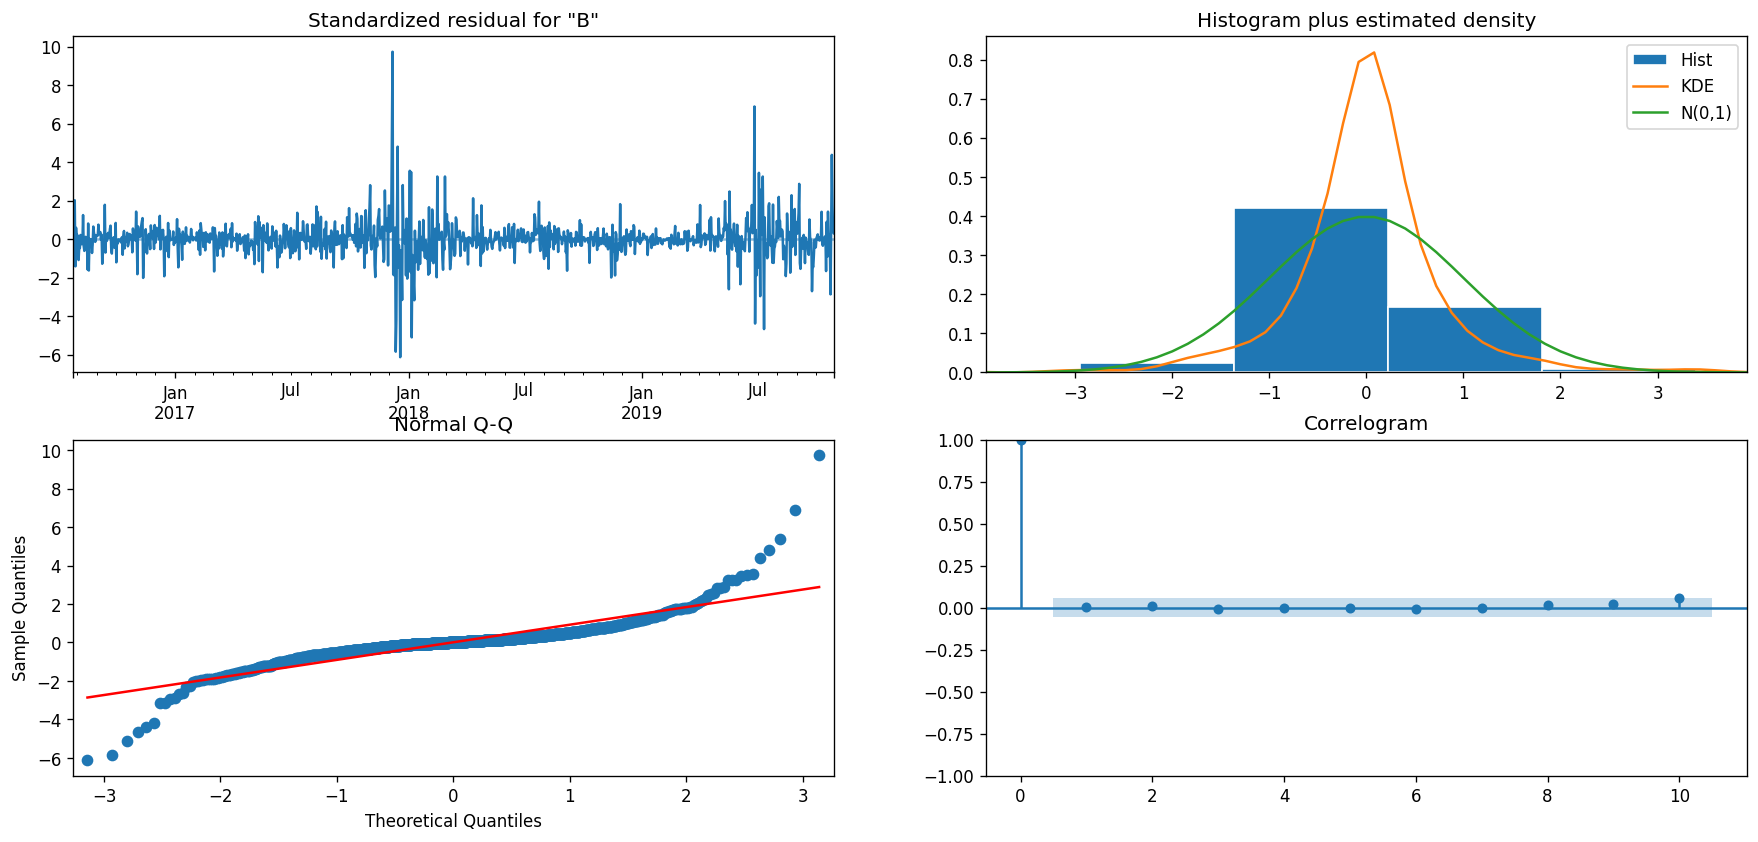

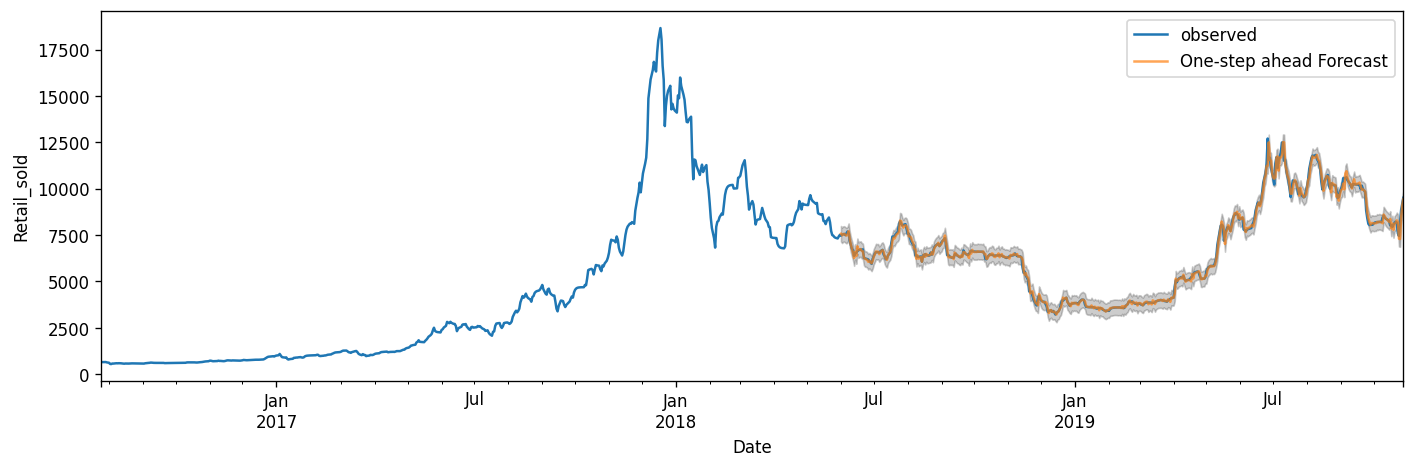

In [123]:
# fit model

exog_data = data_full[['Gold', 'Silver', 'Yuan', 'LTC', 'ETH']]
model = SARIMAX(data_full['BTC'], exog = exog_data, 
                order=(3, 0, 10), seasonal_order=(0, 0, 0, 48*30))
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()
# make prediction

pred = model_fit.get_prediction(start=pd.to_datetime('2018-06-01'), dynamic=False)

pred_ci = pred.conf_int()
ax = data.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()



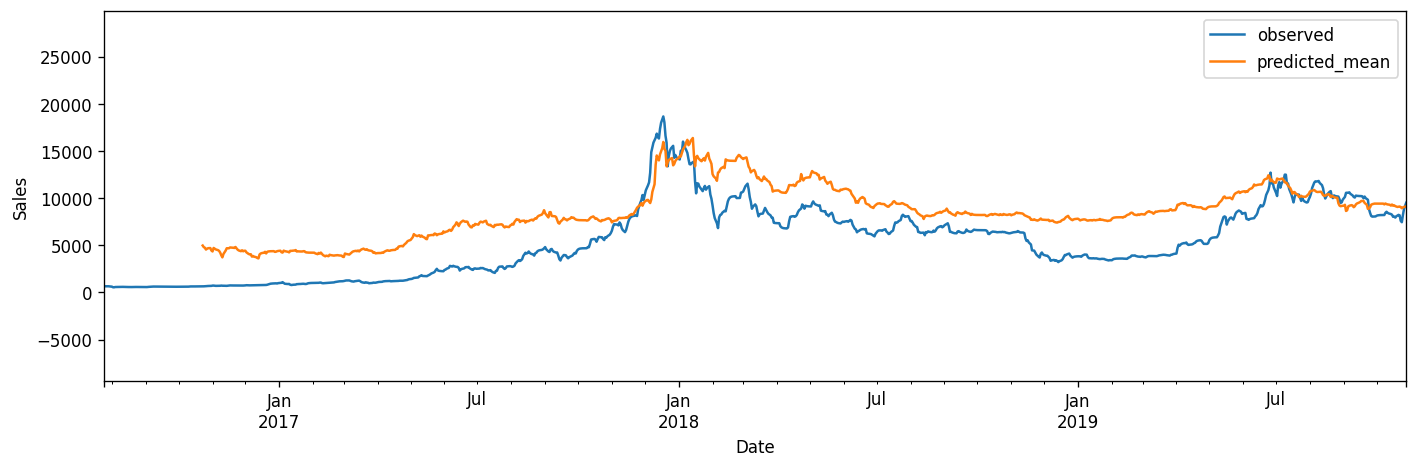

In [124]:
# make forecast
forecast_n = 1100
exog = pd.DataFrame([[x + random(),x + random(),x + random()] for x in range(0,forecast_n)])

exog = exog_data.iloc[-forecast_n:]
exog['Date'] = range(len(data_full),len(data_full)+ forecast_n)
exog['Date'] = pd.date_range(data_full.index[-1],periods =  forecast_n)

exog = exog.set_index('Date')
#print(exog)
#exog.index.freq = None

pred_uc = model_fit.get_forecast(steps=forecast_n, exog=exog)
pred_ci = pred_uc.conf_int()
ax = data_full['BTC'].plot(label='observed', figsize=(14, 4))

#print(data_full.index.freq,'\n',ax.freq,'\n\n')
#print(pred_uc.predicted_mean)
pred_line = pd.DataFrame(pred_uc.predicted_mean)
pred_line['Date'] = pd.date_range(data_full.index[-(1+forecast_n)],periods =  forecast_n)
pred_line = pred_line.set_index('Date')
#print(pred_line)

pred_line.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

<Axes: xlabel='Date'>

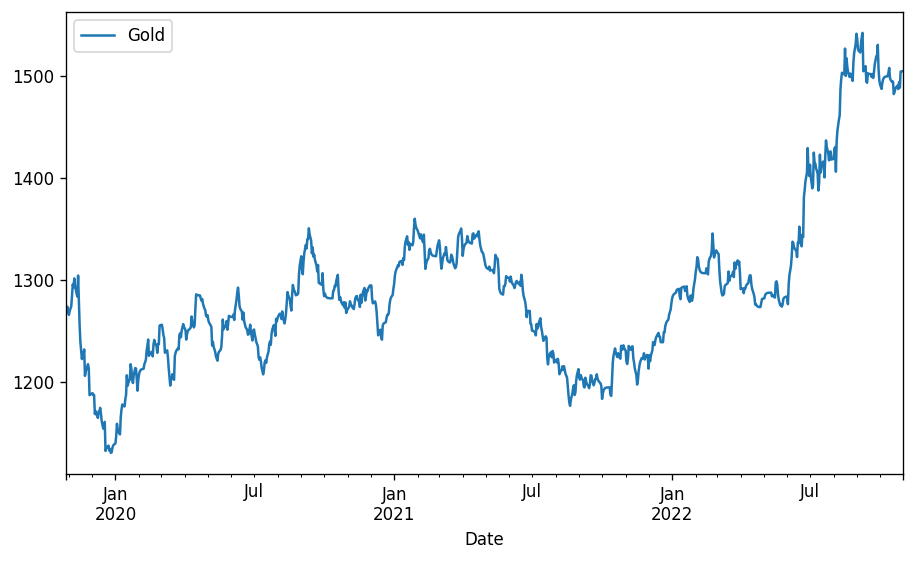

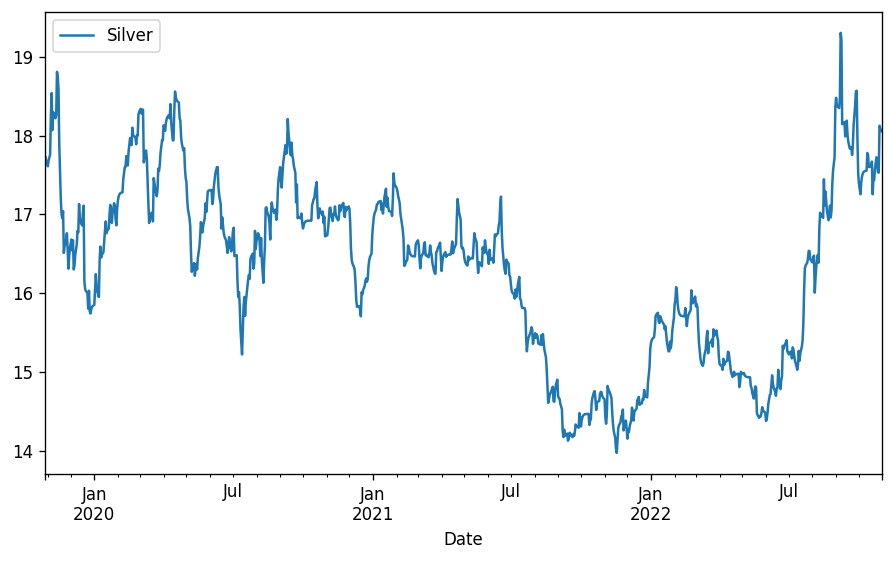

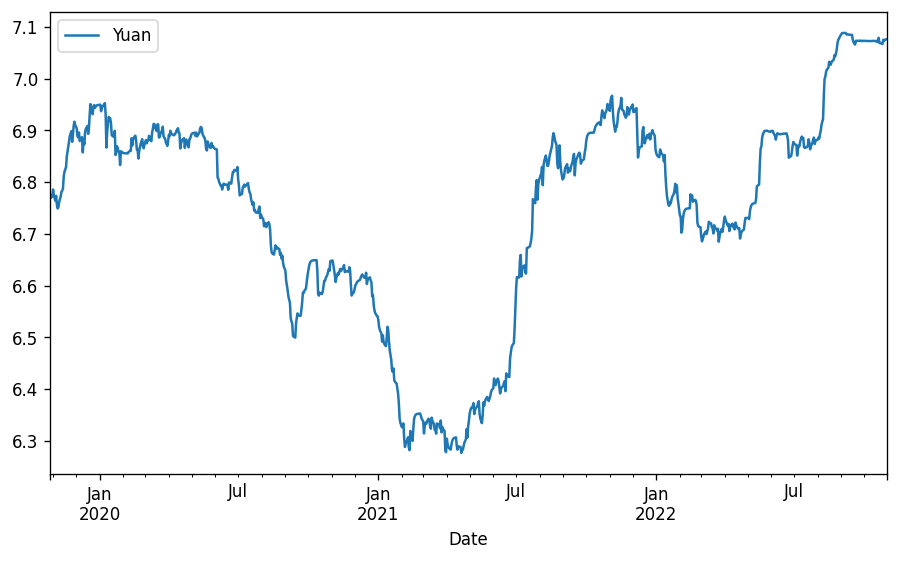

In [125]:
exog[['Gold']].plot()
exog[['Silver']].plot()
exog[['Yuan']].plot()

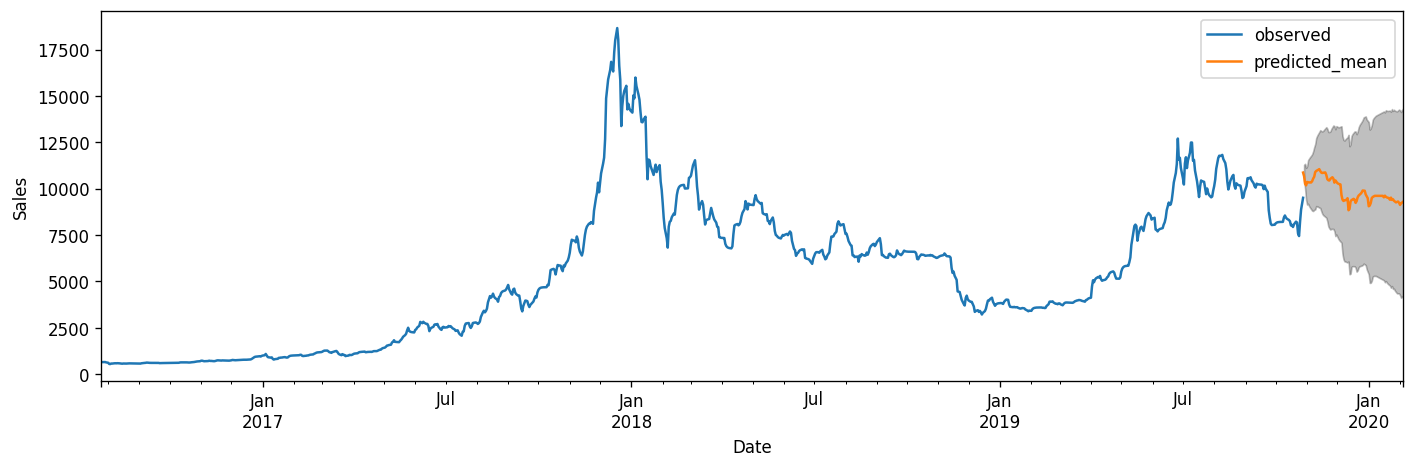

In [128]:
# make forecast
forecast_n = 100
exog = pd.DataFrame([[x + random(),x + random(),x + random()] for x in range(0,forecast_n)])

exog = exog_data.iloc[-forecast_n:]
exog['Date'] = range(len(data_full),len(data_full)+ forecast_n)
exog['Date'] = pd.date_range(data_full.index[-1],periods =  forecast_n)

exog = exog.set_index('Date')
#print(exog)
#exog.index.freq = None

pred_uc = model_fit.get_forecast(steps=forecast_n, exog=exog)
pred_ci = pred_uc.conf_int()
ax = data_full['BTC'].plot(label='observed', figsize=(14, 4))

#print(data_full.index.freq,'\n',ax.freq,'\n\n')
#print(pred_uc.predicted_mean)
pred_line = pd.DataFrame(pred_uc.predicted_mean)
pred_line['Date'] = pd.date_range(data_full.index[-1],periods =  forecast_n)
pred_line = pred_line.set_index('Date')
#print(pred_line)

pred_line.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()